Copyright ENEOS Corporation as contributors to Matlantis contrib project.

In [1]:
import os
import sys
import glob
import shutil

from pathlib import Path
from io import StringIO
from time import perf_counter

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ase import Atoms, units
from ase.io import read, write, Trajectory
from IPython.display import display

In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


### System Settings

In [3]:
# --- System settings
molecule_name = 'DMSO'
nmols = 50
name_smiles = {'DMSO':'CS(=O)C'}
bulk_name = 'Si'

repeat_mol = [3,3,3]
repeat_solid = [3,3,3]

# --- Initial geometry settings
fmax_opt = 0.03
steps_opt = 200
fmax_isolated = 0.01
fmax_liquid = 0.1

# --- MD settings ----
# Please change based on configuration
target_temp = 300
target_pressure = 101325 * units.Pascal
steps_equilib = 10000
steps_product = 10000
timestep_solid = 2.0
timestep_mol = 1.0
temperature = 300

# --- Parameters
mass_density_factor = units._amu * 1e30 
huge = 999.0
# ------------------

In [4]:
invcm = 1/(units._c * 100)  
eV2kJmol = units.mol/units.kJ 
eV2invcm = 1/(100 * units.J * units._hplanck * units._c)
eV2kJmol = units.mol/units.kJ
kT_kJmol = (eV2kJmol * units.kB * target_temp)
beta_kJmol = 1/kT_kJmol
kT = units.kB/units.J * target_temp
beta = 1.0/kT

### Read MD Results

In [5]:
outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

In [6]:
prefix = 'mol'
timestep = timestep_mol
prefix_product = f'{prefix}_product{int(timestep*steps_equilib/1000)}ps'
traj_mol = read(f'{outputdir}/{prefix_product}_{temperature}K.traj', index=':')
#traj_mol = read('DMSO_product.traj', index=':')
print(len(traj_mol))
print(traj_mol[0])

prefix = 'solid'
timestep = timestep_solid
prefix_product = f'{prefix}_product{int(timestep*steps_equilib/1000)}ps'
traj_solid = read(f'{outputdir}/{prefix_product}_{temperature}K.traj', index=':')
print(len(traj_solid))
print(traj_solid[0])

trajs = [traj_solid, traj_mol]
#print(len(traj_solid), len(traj_mol))

10000
Atoms(symbols='C54H162O27S27', pbc=True, cell=[15.40661223024825, 15.40661223024825, 15.40661223024825], momenta=..., calculator=SinglePointCalculator(...))
10000
Atoms(symbols='Si216', pbc=True, cell=[[16.277818172140204, 0.013708953081524762, 0.010565936586134058], [0.0, 16.30503468836646, -0.007540314189872502], [0.0, 0.0, 16.302215584470968]], momenta=..., calculator=SinglePointCalculator(...))


### Check the MD results

In [7]:
def plot_md_result(traj):
    volume_list = [atoms.get_volume() for atoms in traj]
    density_list = [atoms.get_global_number_of_atoms() / atoms.get_volume() for atoms in traj]
    energy_list = [atoms.calc.get_potential_energy() for atoms in traj]
    temperature_list = [atoms.get_temperature() for atoms in traj]
    velocity_list = [np.linalg.norm(atoms.get_velocities(), axis=1).mean() for atoms in traj]
    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 12))

    axes[0].plot(volume_list)
    axes[0].set_title("Volume")

    axes[1].plot(density_list)
    axes[1].set_title("Density")

    axes[2].plot(energy_list)
    axes[2].set_title("Energy")

    axes[3].plot(temperature_list)
    axes[3].set_title("Temperature")

    axes[4].plot(velocity_list)
    axes[4].set_title("Velocity")
    axes[4].set_xlabel("step")

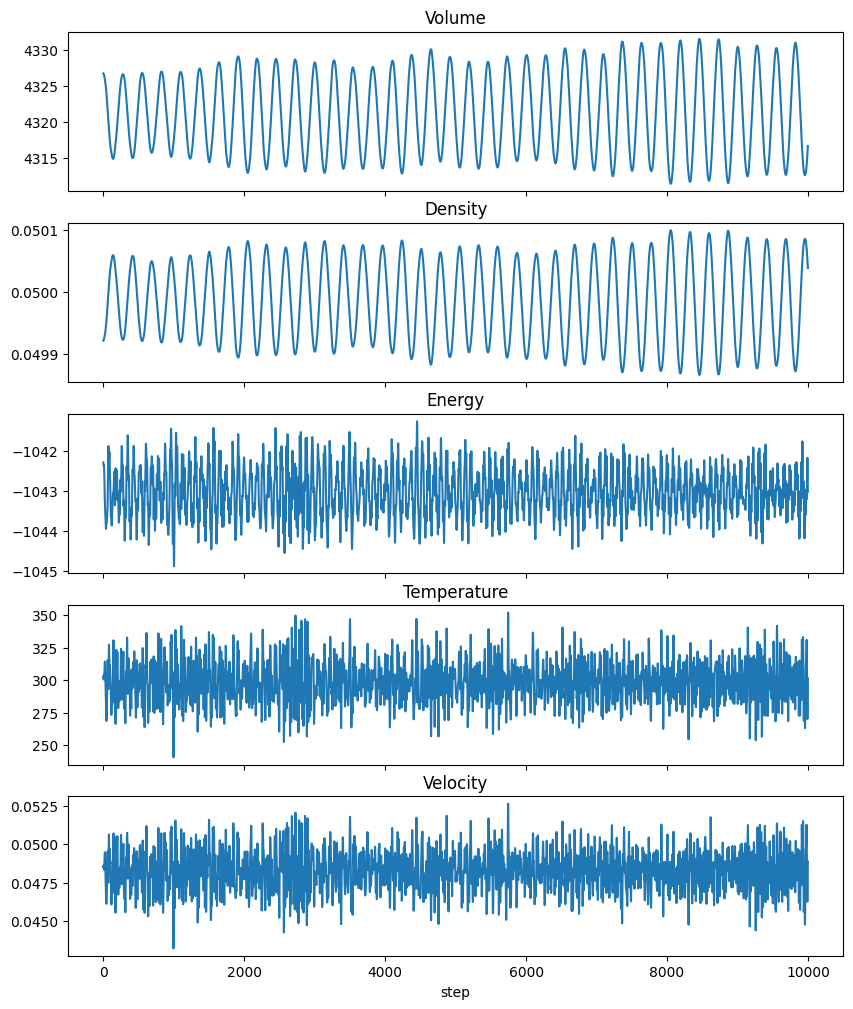

In [8]:
plot_md_result(traj_solid)

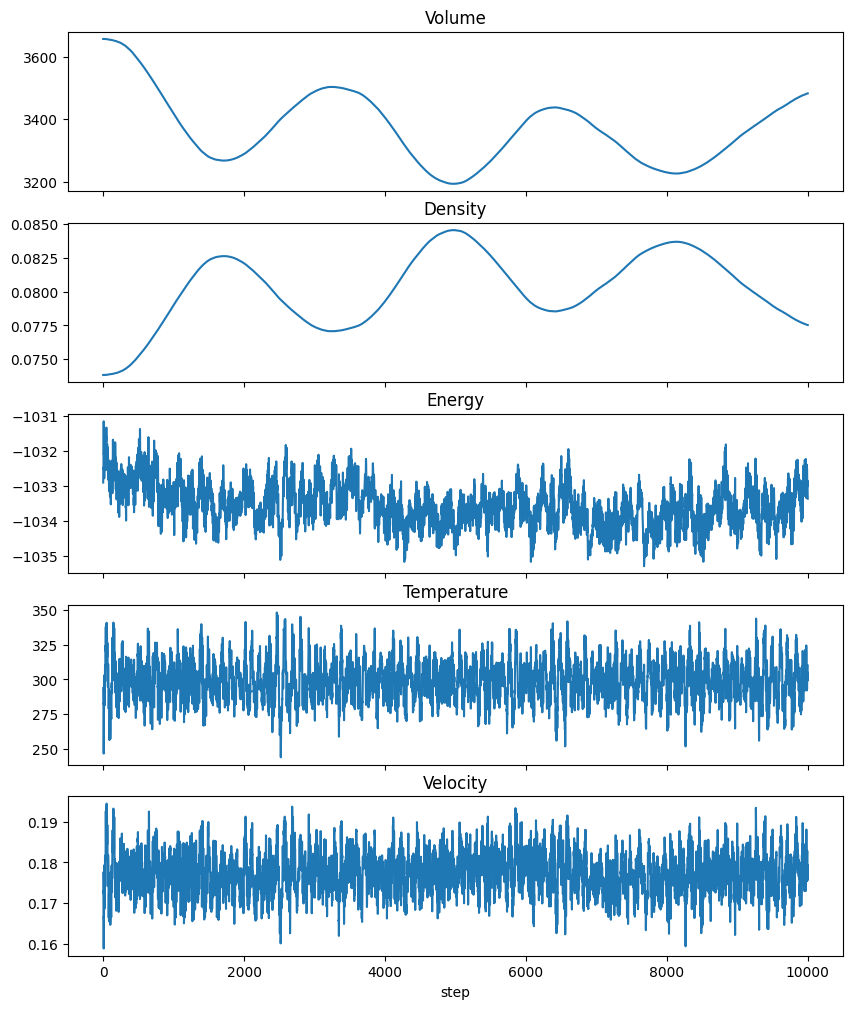

In [9]:
plot_md_result(traj_mol)

In [10]:
for traj, prefix in zip(trajs, ('solid', 'mol')):
    atoms = traj[-1]
    masses = atoms.get_masses()
    vol = atoms.get_volume()
    print(f'# --> {prefix}')
    print(f'{masses[0]} amu = {masses[0]*units._amu:.4e} kg')
    print(f'{vol:.2f} Ang^3 = {vol*1e-30:.4e} m^3')
    print(f'{masses.sum() * units._amu / (vol * 1e-30):.4f} kg/m^3')

v = view_ngl(traj_solid, ['ball+stick'], replace_structure=True, h=300)
display(v)

v = view_ngl(traj_mol, ['ball+stick'], replace_structure=True, h=300)
display(v)

# --> solid
28.085 amu = 4.6636e-26 kg
4316.67 Ang^3 = 4.3167e-27 m^3
2333.6117 kg/m^3
# --> mol
12.011 amu = 1.9945e-26 kg
3482.74 Ang^3 = 3.4827e-27 m^3
1005.7835 kg/m^3
